In [1]:
import json, tqdm, os, re, string, requests, pprint, xml.etree.ElementTree
import collections, seaborn, pickle, os
import functools, itertools
import matplotlib.pyplot as plt
import numpy

In [2]:
def read_file(file_path):
    all_judgments_from_file = []
    with open (file_path) as file:
        json_content = json.load(file)
        item_count = 0
        for item in json_content:
            item_count += 1
            text_content = re.sub("<.*?>", "", item["textContent"])
            text_content = text_content.replace('-\n', '')
            text_content = text_content.replace("\n", '')
            all_judgments_from_file.append((text_content, item["judgmentDate"]))
    return all_judgments_from_file
       
        
def read_all_judgments_from_2018():
    all_judgments = []
    for filename in tqdm.tqdm(os.listdir("data/")):
        judgments = read_file("data/" + filename)
        all_judgments.append(judgments)
    flatten_judgments = [item for sublist in all_judgments for item in sublist]
    return flatten_judgments

def take_oldest_judgments(judgments, how_many=100):
    judgments_sorted = sorted(judgments, key=lambda x: x[1])
    judgments_sorted = [judgment[0] for judgment in judgments_sorted]
    return judgments_sorted[:how_many]

In [3]:
judgments = read_all_judgments_from_2018()

100%|██████████| 11/11 [00:00<00:00, 20.42it/s]


In [4]:
judgments = take_oldest_judgments(judgments)

In [5]:
URL = "http://ws.clarin-pl.eu/nlprest2/base/process"

In [6]:
def process_content(content):
    obj = {
        "lpmn": 'any2txt|wcrft2|liner2({"model":"n82"})',
        "text": content, "user" : "pjn@agh.edu.pl"
    }
    decoder = json.JSONEncoder()
    decoded_obj = decoder.encode(obj)
    req = requests.post(URL, data=decoded_obj)
  
    return xml.etree.ElementTree.fromstring(req.text), req.text

In [7]:
def extract_entities_from_xml(req_xml, result_dict):
    for item in req_xml.iter():
        if item.tag == 'tok':
            for child in item.getchildren():
                if child.tag == 'orth':
                    content = child.text
                if child.tag == 'ann' and child.text == '1':
                    entity = child.attrib['chan']
                    entities[(content, entity)] += 1

In [8]:
req_xml, req_text = process_content("Władysław Jagiełło urodził się na Litwie. Wyjechał potem do Lwowa.")
pprint.pprint(req_text[:500])

('<?xml version="1.0" encoding="UTF-8"?>\n'
 '<!DOCTYPE chunkList SYSTEM "ccl.dtd">\n'
 '<chunkList>\n'
 ' <chunk type="p" id="ch1">\n'
 '  <sentence id="s1">\n'
 '   <tok>\n'
 '    <orth>Władysław</orth>\n'
 '    <lex '
 'disamb="1"><base>Władysław</base><ctag>subst:sg:nom:m1</ctag></lex>\n'
 '    <ann chan="nam_liv_person">1</ann>\n'
 '    <ann chan="nam_loc_gpe_country">0</ann>\n'
 '   </tok>\n'
 '   <tok>\n'
 '    <orth>Jagiełło</orth>\n'
 '    <lex disamb="1"><base>Jagiełło</base><ctag>subst:sg:nom:m1</ctag></lex>\n'
 '    <ann chan="nam_liv_person">1</ann>\n'
 '    <an')


In [9]:
entities = collections.defaultdict(int)

In [10]:
entities

defaultdict(int, {})

In [11]:
def get_last_pickled_entity_idx():
    files = os.listdir('entities_dumps/')
    files = [file for file in files if "pickle" in file]
    if len(files)>0:
        last_file = sorted([int(file.split(".")[0]) for file in files], reverse=True)[0]
    else:
        last_file = 0
    return last_file

In [12]:
def process_judgments():
    last_file = get_last_pickled_entity_idx()
    print ("Proceeding files from" + str(last_file))
    ###############################################################################
    for idx, judgment in tqdm.tqdm(enumerate(judgments[last_file:])):
        xml_content, text = process_content(judgment)
        extract_entities_from_xml(xml_content, entities)
        with open("entities_dumps/" + str(idx+last_file) + ".pickle", 'wb') as file:
            pickle.dump(entities, file) 

In [15]:
process_judgments()

0it [00:00, ?it/s]

Proceeding files from36


64it [42:34, 39.91s/it]


In [16]:
def statistics_for_categories(merge_into_major_categories):
    idx = get_last_pickled_entity_idx()
    file_name = "entities_dumps/" + str(idx) + ".pickle"
    with open(file_name, "rb") as file:
        entities = pickle.load(file)
    categories = entities.items()
    categories = [(category[0][1], category[1]) for category in categories]
    if merge_into_major_categories:
         categories = [
            ("_".join(category[0].split("_")[:2]),
             category[1]) for category in categories]
    
    product_dict = collections.defaultdict(int)
    for category in categories:
        product_dict[category[0]] += category[1]
    
    keys_dict, values_dict = product_dict.keys(), product_dict.values()
    pprint.pprint(list(zip(keys_dict, values_dict)))
    values = list(values_dict)
    keys = list(keys_dict)
    plt.figure(figsize=(25,10))
    plt.bar(numpy.arange(0, len(values)), values)
    
    plt.xticks(numpy.arange(0, len(values)), keys)
    plt.show()

[('nam_org_organization', 716),
 ('nam_oth_currency', 595),
 ('nam_liv_person', 2458),
 ('nam_org_institution', 3653),
 ('nam_loc_gpe_city', 207),
 ('nam_fac_road', 10),
 ('nam_loc_gpe_country', 24),
 ('nam_fac_goe', 108),
 ('nam_pro_title_document', 1407),
 ('nam_pro_media_periodic', 577),
 ('nam_eve_human_sport', 18),
 ('nam_num_house', 1),
 ('nam_org_company', 556),
 ('nam_org_group_team', 46),
 ('nam_org_nation', 3),
 ('nam_pro_title', 22),
 ('nam_num_phone', 2),
 ('nam_oth_tech', 97),
 ('nam_pro_brand', 50),
 ('nam_eve_human', 4),
 ('nam_oth_other', 63),
 ('nam_loc_land_continent', 2),
 ('nam_pro_media_web', 6),
 ('nam_org_political_party', 31),
 ('nam_fac_system', 5),
 ('nam_adj_country', 1),
 ('nam_adj_other', 2),
 ('nam_org_group_band', 6),
 ('nam_adj_city', 2),
 ('nam_pro_model_car', 2),
 ('nam_loc_gpe_district', 2),
 ('nam_pro_title_treaty', 1),
 ('nam_loc_gpe_admin1', 3),
 ('nam_oth_license', 2),
 ('nam_pro_software', 2),
 ('nam_liv_god', 2),
 ('nam_pro_award', 1),
 ('nam_lo

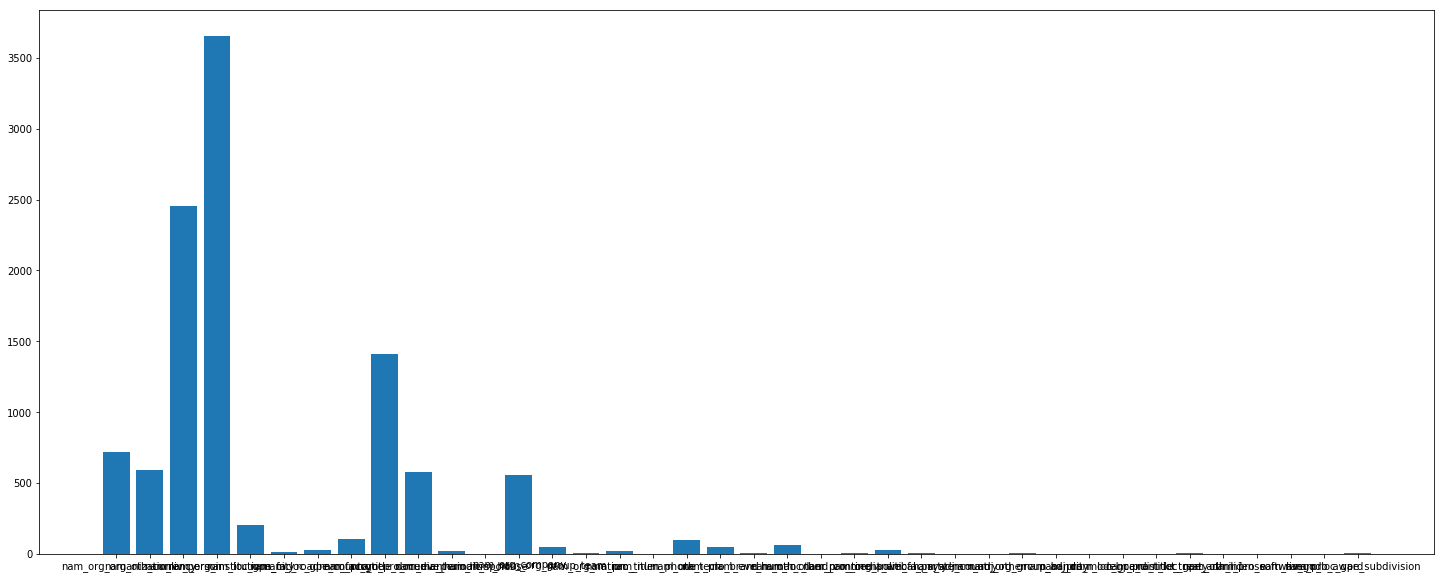

In [17]:
statistics_for_categories(merge_into_major_categories=False)

[('nam_org', 5011),
 ('nam_oth', 757),
 ('nam_liv', 2460),
 ('nam_loc', 243),
 ('nam_fac', 123),
 ('nam_pro', 2068),
 ('nam_eve', 22),
 ('nam_num', 3),
 ('nam_adj', 5)]


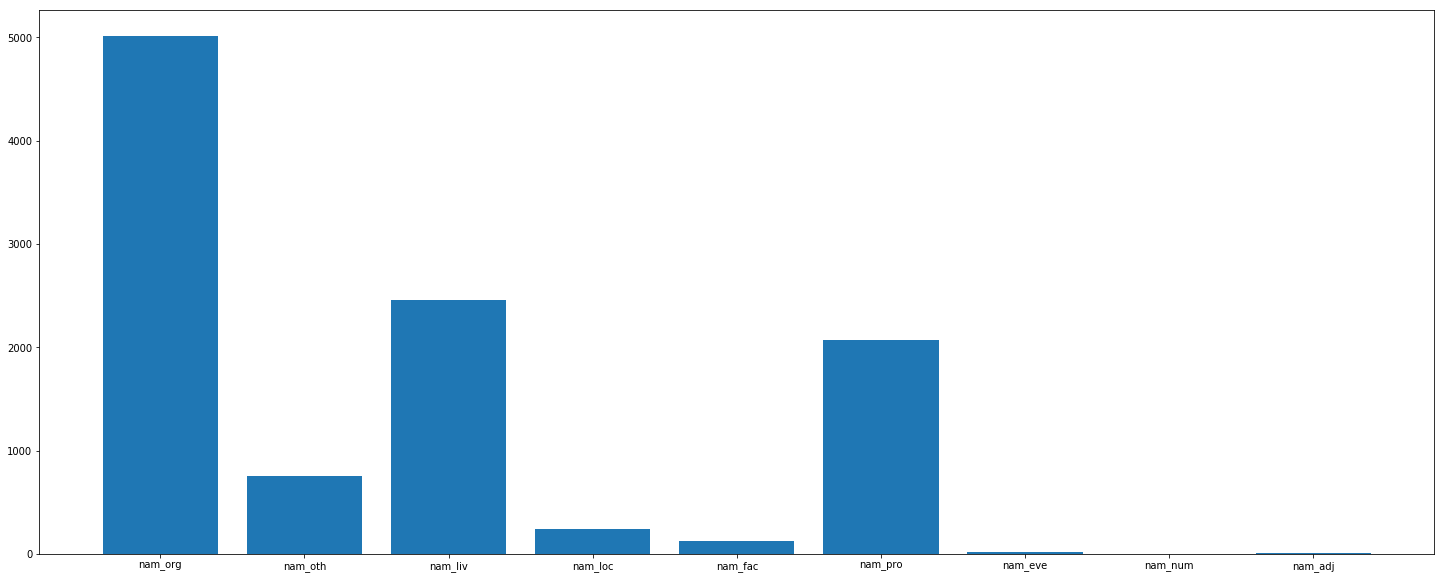

In [18]:
statistics_for_categories(merge_into_major_categories=True)

In [19]:
idx = get_last_pickled_entity_idx()
file_name = "entities_dumps/" + str(idx) + ".pickle"
with open(file_name, "rb") as file:
    entities = pickle.load(file)
elements = list(entities.items())
elements = sorted(elements, key=lambda x: x[1], reverse=True)
pprint.pprint(elements[:100])

[(('.', 'nam_liv_person'), 601),
 (('zł', 'nam_oth_currency'), 522),
 (('Sąd', 'nam_org_institution'), 456),
 (('M', 'nam_liv_person'), 313),
 (('.', 'nam_pro_media_periodic'), 272),
 (('Sądu', 'nam_org_institution'), 242),
 (('D', 'nam_liv_person'), 199),
 (('J', 'nam_liv_person'), 178),
 (('Okręgowy', 'nam_org_institution'), 170),
 (('Rejonowy', 'nam_org_institution'), 165),
 (('w', 'nam_org_institution'), 145),
 (('Dz', 'nam_pro_media_periodic'), 142),
 (('U', 'nam_pro_media_periodic'), 140),
 (('Ubezpieczeń', 'nam_org_institution'), 139),
 (('Społecznych', 'nam_org_institution'), 139),
 (('Najwyższego', 'nam_org_institution'), 123),
 (('B', 'nam_liv_person'), 122),
 (('o', 'nam_pro_title_document'), 113),
 (('ustawy', 'nam_pro_title_document'), 113),
 (('S', 'nam_liv_person'), 107),
 (('z', 'nam_pro_title_document'), 104),
 (('Pracy', 'nam_org_institution'), 102),
 (('.', 'nam_org_company'), 89),
 (('dnia', 'nam_pro_title_document'), 86),
 (('G', 'nam_liv_person'), 85),
 (('P', 'na

In [21]:
# Przedstaw 10 najczęstszych wyrażeń, dla każdej wysokopoziomowej (zgrubnej) klasy wyrażeń.
idx = get_last_pickled_entity_idx()
file_name = "entities_dumps/" + str(idx) + ".pickle"
with open(file_name, "rb") as file:
    entities = pickle.load(file)
elements = entities.items()

elements_major_categories = []
for element in elements:
    category = element[0][1]
    major_category = "_".join(category.split("_")[:2])
    word_cat_tuple = (element[0][0], major_category)
    count = element[1]
    elements_major_categories.append((word_cat_tuple, count))

elements = elements_major_categories

elements = sorted(elements, key = lambda x: x[0][1], reverse=True)
grouped_by = itertools.groupby(elements, lambda x: x[0][1])
for key, group in grouped_by:
    idx = 1
    for thing in sorted(group, key= lambda x: x[1], reverse=True):
        if idx>20:
                continue
        idx+=1
        print (thing, key)
    print("##################")

(('.', 'nam_pro'), 272) nam_pro
(('Dz', 'nam_pro'), 142) nam_pro
(('U', 'nam_pro'), 140) nam_pro
(('o', 'nam_pro'), 113) nam_pro
(('ustawy', 'nam_pro'), 113) nam_pro
(('z', 'nam_pro'), 104) nam_pro
(('dnia', 'nam_pro'), 86) nam_pro
(('r', 'nam_pro'), 46) nam_pro
(('.', 'nam_pro'), 46) nam_pro
(('w', 'nam_pro'), 38) nam_pro
(('emeryturach', 'nam_pro'), 33) nam_pro
(('Ministra', 'nam_pro'), 26) nam_pro
(('sprawach', 'nam_pro'), 25) nam_pro
(('roku', 'nam_pro'), 24) nam_pro
(('i', 'nam_pro'), 23) nam_pro
(('października', 'nam_pro'), 22) nam_pro
(('kosztach', 'nam_pro'), 22) nam_pro
(('sądowych', 'nam_pro'), 22) nam_pro
(('cywilnych', 'nam_pro'), 22) nam_pro
(('rozporządzenia', 'nam_pro'), 18) nam_pro
##################
(('zł', 'nam_oth'), 522) nam_oth
(('złotych', 'nam_oth'), 63) nam_oth
(('VAT', 'nam_oth'), 31) nam_oth
(('VIN', 'nam_oth'), 21) nam_oth
(('VAT', 'nam_oth'), 18) nam_oth
(('23', 'nam_oth'), 15) nam_oth
(('1', 'nam_oth'), 15) nam_oth
(('C', 'nam_oth'), 13) nam_oth
(('CD', 'n